# Predicting Lung Cancer and Survey Analysis

## Summary/ Introduction

This notebook analyzes survey responses to identify behavioral and demographic factors linked to lung cancer. Using permutation-based feature importance, we find that 3 out of 15 survey questions do not contribute to predicting the presence of lung cancer. By identifying useless survey questions, survey fatigue can be reduced and user experience can be improved. By surfacing high-risk patterns in survey responses, this approach offers a potential tool for early detection and clinical follow-up.

## Data Overview

The [Lung Cancer Dataset](https://www.kaggle.com/datasets/aagambshah/lung-cancer-dataset) contains **309 survey responses** capturing demographic and behavioral factors. The target variable is `LUNG_CANCER`, indicating whether a respondent has been diagnosed with lung cancer. Below is a description of each feature:

| Feature Name            | Description                                      |
| ----------------------- | ------------------------------------------------ |
| `GENDER`                | Gender of the respondent (Male/Female)           |
| `AGE`                   | Age of the respondent                            |
| `SMOKING`               | Smoking habit (Yes/No)                           |
| `YELLOW_FINGERS`        | Presence of yellowing fingers (Yes/No)           |
| `ANXIETY`               | Presence of anxiety (Yes/No)                     |
| `PEER_PRESSURE`         | Experience of peer pressure (Yes/No)             |
| `CHRONIC DISEASE`       | Existing chronic diseases (Yes/No)               |
| `FATIGUE`               | Presence of fatigue (Yes/No)                     |
| `ALLERGY`               | Allergic conditions (Yes/No)                     |
| `WHEEZING`              | Wheezing symptoms (Yes/No)                       |
| `ALCOHOL CONSUMING`     | Alcohol consumption habit (Yes/No)               |
| `COUGHING`              | Frequent coughing (Yes/No)                       |
| `SHORTNESS OF BREATH`   | Symptom of shortness of breath (Yes/No)          |
| `SWALLOWING DIFFICULTY` | Difficulty in swallowing (Yes/No)                |
| `CHEST PAIN`            | Presence of chest pain (Yes/No)                  |
| `LUNG_CANCER`           | Lung cancer diagnosis (target variable) (Yes/No) |


## Imports

In [48]:
# Core libraries
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Kaggle dataset access
import kagglehub

# Imbalance
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC, SMOTEN

# Scikit-learn: modeling and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance

from sklearn.metrics import (
    average_precision_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay
)

## Data Cleaning & Preprocessing

In [49]:
# Download latest version
path = kagglehub.dataset_download("aagambshah/lung-cancer-dataset")

# Load dataset into DataFrame
df = pd.read_csv(os.path.join(path, 'survey lung cancer.csv'))

# Preview
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [50]:
# Understand the size of the dataset
df.shape

(309, 16)

In [51]:
# Check for nulls
df.isna().sum()

GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL CONSUMING        0
COUGHING                 0
SHORTNESS OF BREATH      0
SWALLOWING DIFFICULTY    0
CHEST PAIN               0
LUNG_CANCER              0
dtype: int64

In [52]:
# Check data types
df.dtypes

GENDER                   object
AGE                       int64
SMOKING                   int64
YELLOW_FINGERS            int64
ANXIETY                   int64
PEER_PRESSURE             int64
CHRONIC DISEASE           int64
FATIGUE                   int64
ALLERGY                   int64
WHEEZING                  int64
ALCOHOL CONSUMING         int64
COUGHING                  int64
SHORTNESS OF BREATH       int64
SWALLOWING DIFFICULTY     int64
CHEST PAIN                int64
LUNG_CANCER              object
dtype: object

In [53]:
# View unique values
for col in df.select_dtypes(include=['object', 'int64']):
    print(f'{col}: {df[col].unique()}')

GENDER: ['M' 'F']
AGE: [69 74 59 63 75 52 51 68 53 61 72 60 58 48 57 44 64 21 65 55 62 56 67 77
 70 54 49 73 47 71 66 76 78 81 79 38 39 87 46]
SMOKING: [1 2]
YELLOW_FINGERS: [2 1]
ANXIETY: [2 1]
PEER_PRESSURE: [1 2]
CHRONIC DISEASE: [1 2]
FATIGUE : [2 1]
ALLERGY : [1 2]
WHEEZING: [2 1]
ALCOHOL CONSUMING: [2 1]
COUGHING: [2 1]
SHORTNESS OF BREATH: [2 1]
SWALLOWING DIFFICULTY: [2 1]
CHEST PAIN: [2 1]
LUNG_CANCER: ['YES' 'NO']


In [54]:
# Clean column names
df.columns = df.columns.str.strip().str.replace(' ', '_')

In [55]:
# Helper function
def one_hot_encode(array, positive_class):
    """
    Encodes a binary categorical array into 0s and 1s based on a specified positive class.

    Parameters:
        array (array-like): Input array containing binary values (e.g., 'Yes'/'No', 1/2).
        positive_class (str or int): The class to encode as 1. All other values become 0.

    Returns:
        np.ndarray: Array of 0s and 1s, where 1 represents the positive_class.
    """
    return np.where(array == positive_class, 1, 0)


In [56]:
# One-hot encode
df_encoded = df.copy()
df_encoded.GENDER = one_hot_encode(df.GENDER.values, 'M')
df_encoded.SMOKING = one_hot_encode(df.SMOKING.values, 2)
df_encoded.YELLOW_FINGERS = one_hot_encode(df.YELLOW_FINGERS.values, 2)
df_encoded.ANXIETY = one_hot_encode(df.ANXIETY.values, 2)
df_encoded.PEER_PRESSURE = one_hot_encode(df.PEER_PRESSURE.values, 2)
df_encoded.CHRONIC_DISEASE = one_hot_encode(df.CHRONIC_DISEASE.values, 2)
df_encoded.FATIGUE = one_hot_encode(df.FATIGUE.values, 2)
df_encoded.ALLERGY = one_hot_encode(df.ALLERGY.values, 2)
df_encoded.WHEEZING = one_hot_encode(df.WHEEZING.values, 2)
df_encoded.ALCOHOL_CONSUMING = one_hot_encode(df.ALCOHOL_CONSUMING.values, 2)
df_encoded.COUGHING = one_hot_encode(df.COUGHING.values, 2)
df_encoded.SHORTNESS_OF_BREATH = one_hot_encode(df.SHORTNESS_OF_BREATH.values, 2)
df_encoded.SWALLOWING_DIFFICULTY = one_hot_encode(df.SWALLOWING_DIFFICULTY.values, 2)
df_encoded.CHEST_PAIN = one_hot_encode(df.CHEST_PAIN.values, 2)
df_encoded.LUNG_CANCER = one_hot_encode(df.LUNG_CANCER.values, 'YES')

# Preview
df_encoded.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC_DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL_CONSUMING,COUGHING,SHORTNESS_OF_BREATH,SWALLOWING_DIFFICULTY,CHEST_PAIN,LUNG_CANCER
0,1,69,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,1,74,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,0,59,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,1,63,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,0,63,0,1,0,0,0,0,0,1,0,1,1,0,0,0


## Exploratory Data Analysis (EDA)

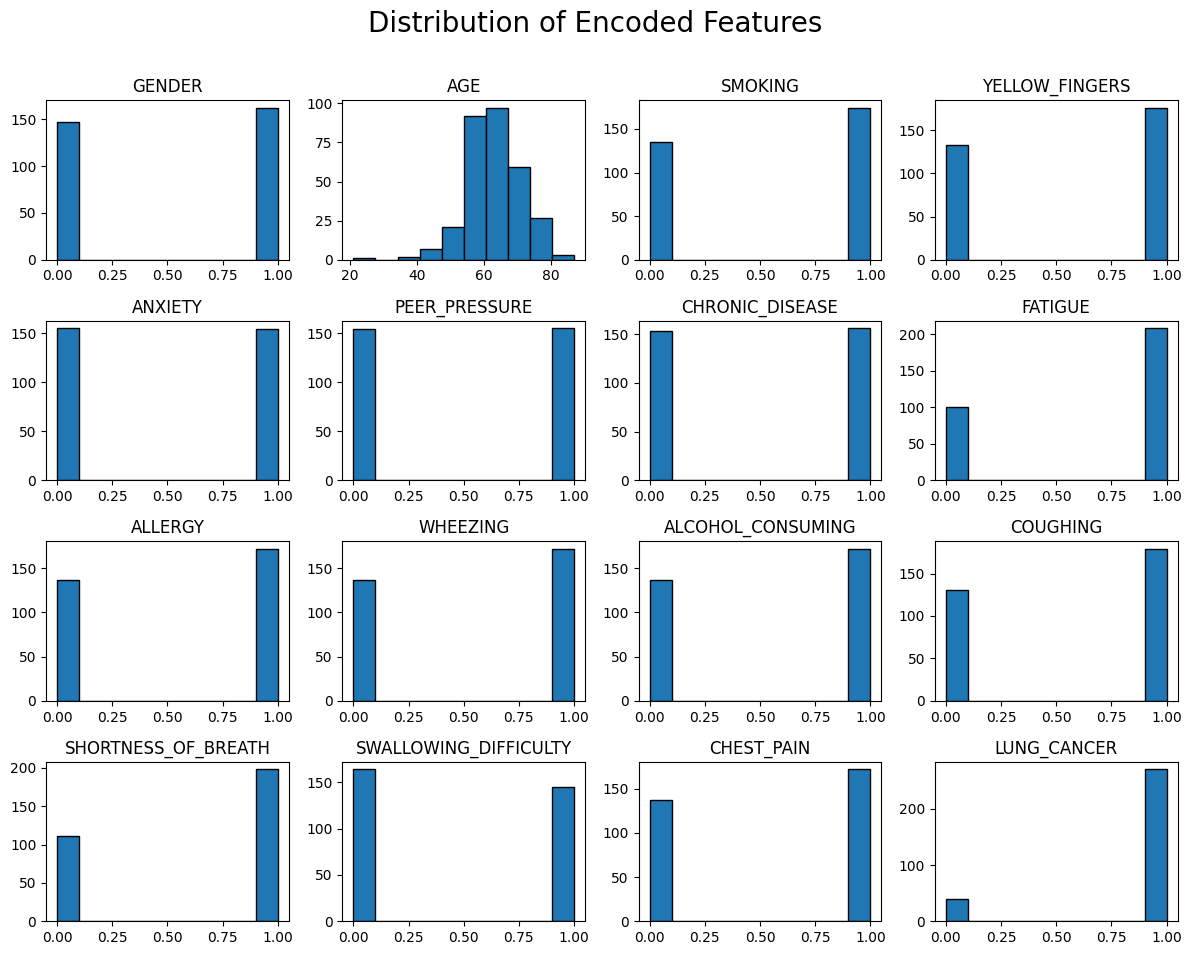

In [57]:
# Histograms of all features
ax = df_encoded.hist(figsize=(12, 10), edgecolor='black', grid=False)
plt.suptitle("Distribution of Encoded Features", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

By looking at `LUNG_CANCER`, it becomes obvious that this is an imbalanced dataset with many more cases of lung cancer than those without. Sampling methods will need to be used to prevent the model from becoming biased towards the majority class. The dataset is small and the minority class is even smaller. Undersampling the majority class to be equal size as the minority class would result in a very small dataset and therefore will not be explored. I will stick to oversampling the minority class. Oversampling with SMOTE avoids redundant samples by creating synthetic samples within the original sample space and will be the process I use. I will compare to an equivalant model that does not use any oversampling methods for comparison.

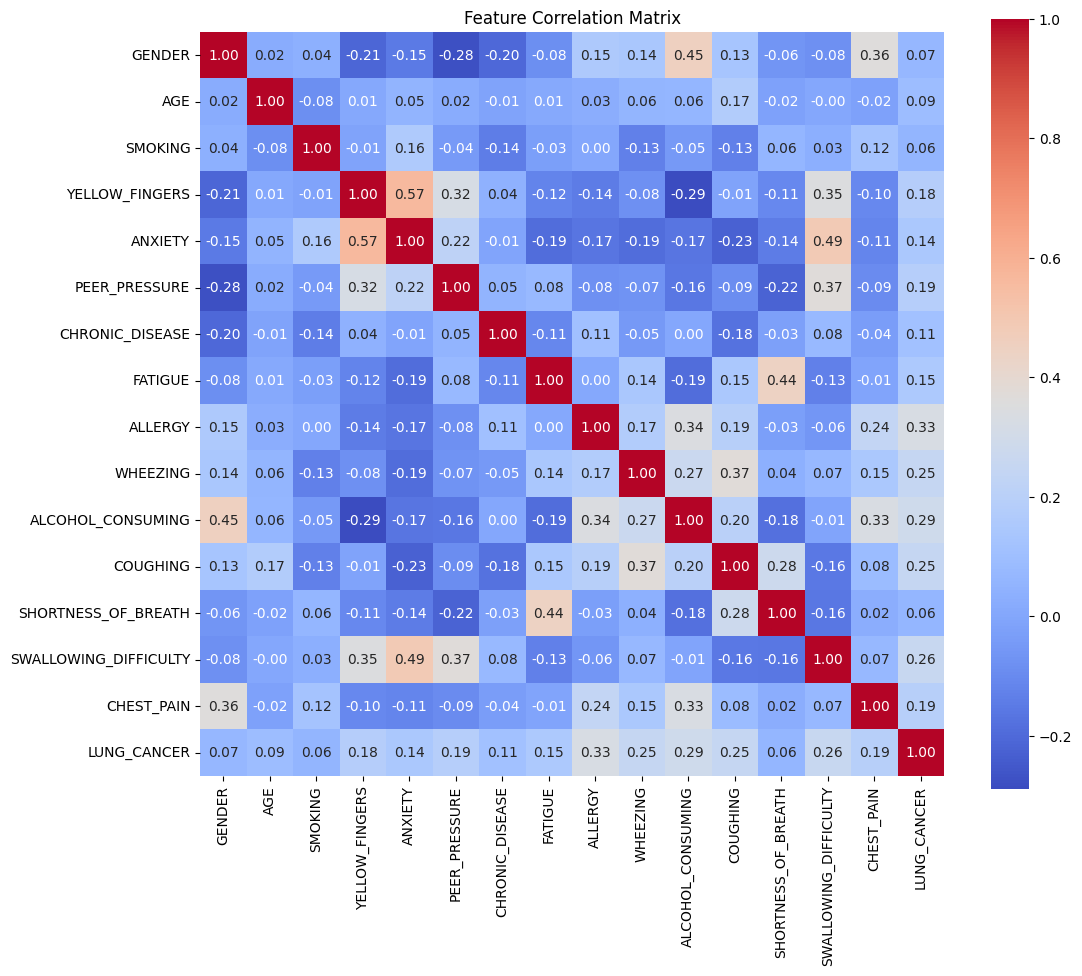

In [58]:
# Check for collinearity
correlation_matrix = df_encoded.corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Feature Correlation Matrix')
plt.show()

The greatest correlation between any two variables 0.57 between `ANXIETY` and `YELLOW_FINGERS` followed by 0.49 between `ANXIETY` and `SWALLOWING_DIFFICULTY`. No action is being taken for the moderate correlation between these features.

## SMOTE Oversampling and Model Scoring
As we are not interested in applying oversampling to our test dataset, SMOTE will be applied only to training data. Specifically the SMOTENC class from imblearn since this dataset has both numerical and categorical features. However, SMOTEN is also imported for use if the only numerical feature is removed from the dataset, as SMOTENC does not work for strictly categorical features.

As the oversampling evens out the target class distribution for the training sets, the models will still be scored using validation sets that do not experience oversampling. Therefore, sklearn's `average_precision_score` will be used to score the models' performance.

## Model Building
The RandomForestClassifier from sklearn was the model of choice for this project as all but one feature are categorical and since feature importance will be considered.

### Datasets
There needs to be a train, validation, and test split of the original dataset. To prevent data leakage in this project, the usage of a pipeline must be used during cross-validation to prevent SMOTE oversampling being applied to the hold out set. The train split will be used for cross-validation while hyperparameter tuning. The best performing model that comes out of the cross-validation will be scored using the validation split to determine permutation-based feature importance. Any features that do not positively contribute to the model's prediction power will be dropped and the process up to this point repeated. However, once the contributing features for the model converge, the model will be trained on the entirety of the train and validation splits with SMOTE oversampling applied. Then the test split will be used to evaluate the performance of the final model.

In [59]:
# Separate features from target
X = df_encoded.drop('LUNG_CANCER', axis=1).values
y = df_encoded['LUNG_CANCER'].values
feature_names = df_encoded.drop('LUNG_CANCER', axis=1).columns

# Split X, y into train and test splits and stratify based on target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

# Split X_train, y_train into train and validation splits and stratify based on y_train (for feature importance scoring)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42, shuffle=True, stratify=y_train)

### Pipeline

In [60]:
def determine_categorical_features(df, numeric_features=[]):
    """Returns column indices of all features in df that are not in numeric_features"""
    features = df.columns
    cat_features = [index for index in range(len(features)) if features[index] not in numeric_features]
    return cat_features

cat_features = determine_categorical_features(df_encoded.drop('LUNG_CANCER', axis=1), numeric_features=['AGE'])

imb_pipe = Pipeline([('smotenc', SMOTENC(categorical_features=cat_features, random_state=42)),
                     ('forest', RandomForestClassifier(random_state=42))])

### Tree-Depth Approach vs Minimum Samples Per Leaf Approach
There are two main hyperparameters in the RandomForestClassifier that aid in generalization and not overfitting to the training dataset. Those are the maximum depth of a tree and the minimum number of training samples required to create a leaf node in a tree.

In [61]:
# Define parameter grids for both approaches
params1 = {'forest__max_depth': list(range(2, 20))}
params2 = {'forest__min_samples_leaf': list(range(1, 20))}

# Create Grid Search objects
grid1 = GridSearchCV(
    estimator=imb_pipe,
    param_grid=params1,
    scoring='average_precision',
    cv=5,
    return_train_score=True
)
grid2 = GridSearchCV(
    estimator=imb_pipe,
    param_grid=params2,
    scoring='average_precision',
    cv=5,
    return_train_score=True
)

# Train
grid1.fit(X_train, y_train)
grid2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smotenc',
                                        SMOTENC(categorical_features=[0, 2, 3,
                                                                      4, 5, 6,
                                                                      7, 8, 9,
                                                                      10, 11,
                                                                      12, 13,
                                                                      14],
                                                random_state=42)),
                                       ('forest',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'forest__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19]},
             return_train_score=True, scoring='average_precision')

### Compare Cross-Validation Results

In [62]:
def plot_cv_results(results1, results2, x1='param_max_depth', x2='min_samples_leaf'):
    """Helper function to visualize cross-validation results between two models."""
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), constrained_layout=True, sharey=True)

    # Left plot
    ax1.plot(results1[x1].astype('int'), results1['mean_train_score'], label='Train')
    ax1.fill_between(results1[x1].astype('int'),
                     [m + s for m, s in zip(results1['mean_train_score'], results1['std_train_score'])],
                     [m - s for m, s in zip(results1['mean_train_score'], results1['std_train_score'])],
                     alpha=0.3)
    
    ax1.plot(results1[x1].astype('int'), results1['mean_test_score'], label='Val')
    ax1.fill_between(results1[x1].astype('int'),
                     [m + s for m, s in zip(results1['mean_test_score'], results1['std_test_score'])],
                     [m - s for m, s in zip(results1['mean_test_score'], results1['std_test_score'])],
                     alpha=0.3)
    
    ax1.legend()
    ax1.set_xlabel(x1)
    ax1.set_ylabel('Average Precision Score')
    ax1.set_title('Maximum Tree Depth Approach')

    # Right plot
    ax2.plot(results2[x2].astype('int'), results2['mean_train_score'], label='Train')
    ax2.fill_between(results2[x2].astype('int'),
                     [m + s for m, s in zip(results2['mean_train_score'], results2['std_train_score'])],
                     [m - s for m, s in zip(results2['mean_train_score'], results2['std_train_score'])],
                     alpha=0.3)
    
    ax2.plot(results2[x2].astype('int'), results2['mean_test_score'], label='Val')
    ax2.fill_between(results2[x2].astype('int'),
                     [m + s for m, s in zip(results2['mean_test_score'], results2['std_test_score'])],
                     [m - s for m, s in zip(results2['mean_test_score'], results2['std_test_score'])],
                     alpha=0.3)
    
    ax2.legend()
    ax2.set_xlabel(x2)
    ax2.set_ylabel('Average Precision Score')
    ax2.set_title('Minimum Samples Per Leaf Approach')
    
    fig.suptitle('Cross-Validation Average Precision Scores')
    plt.show()

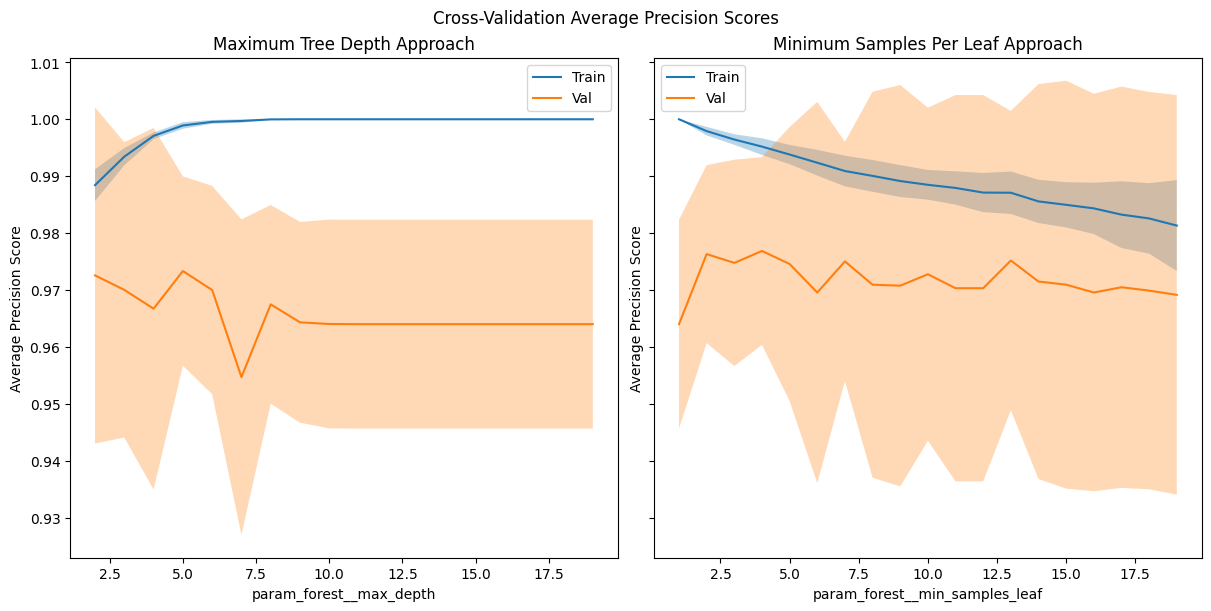

In [63]:
# Plot results
cv_results1 = pd.DataFrame(grid1.cv_results_)[['param_forest__max_depth', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
cv_results2 = pd.DataFrame(grid2.cv_results_)[['param_forest__min_samples_leaf', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
plot_cv_results(cv_results1, cv_results2, x1='param_forest__max_depth', x2='param_forest__min_samples_leaf')

Setting the maximum tree depth leads to overfitting as seen by the continued increase in model performance on the train dataset, but decreased performance on the validation dataset. Setting the minimum samples per leaf leads to better generalization which can be seen by the decrease in training performance, while the validation performance remained relatively constant. Therefore, I will be proceeding with the approach of building the RandomForestClassifier by defining the minimum number of samples required for the creation of a leaf node in its trees.

In [64]:
# Verify we agree with GridSearchCV's best parameters
print(f'Best model parameters: {grid2.best_params_}')
print(f'Best model score: {grid2.best_score_}')

Best model parameters: {'forest__min_samples_leaf': 4}
Best model score: 0.9768531368448583


## Feature Importance (Permutation-Based)
Now that we have a first pass at a successful model, let's measure permutation-based feature importance to decide which survey questions positively impact predictive performance. The model was trained on the train dataset and will now be tested on the validation dataset.

#### Iteration 1

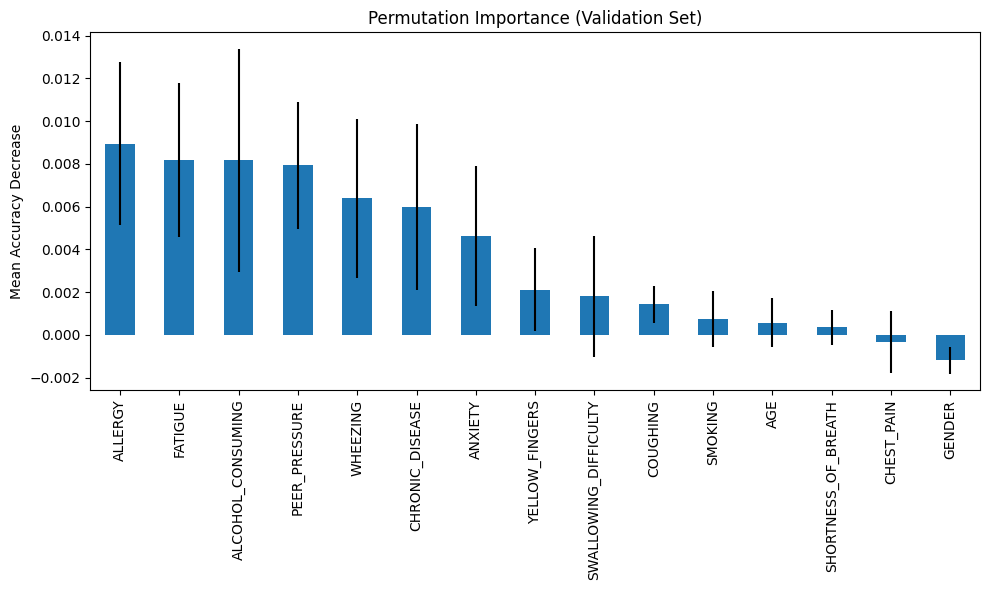

In [65]:
# Compute permutation importance
result = permutation_importance(grid2, X_val, y_val, n_repeats=30, random_state=42, scoring='average_precision')

# Create a sorted Series for plotting
importances = pd.Series(result.importances_mean, index=feature_names)
importances_std = pd.Series(result.importances_std, index=feature_names)
sorted_importances = importances.sort_values(ascending=False)

# Plot with matching error bars
fig, ax = plt.subplots(figsize=(10, 6))
sorted_importances.plot.bar(yerr=importances_std[sorted_importances.index], ax=ax)
ax.set_title("Permutation Importance (Validation Set)")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
plt.show()

Some features impact the predictive performance of the model far more than other, however, `GENDER` and `CHEST_PAIN` both show that the model performance increases when their values are permuted, meaning they are useless. Let's remove them and repeat the process.

#### Iteration 2

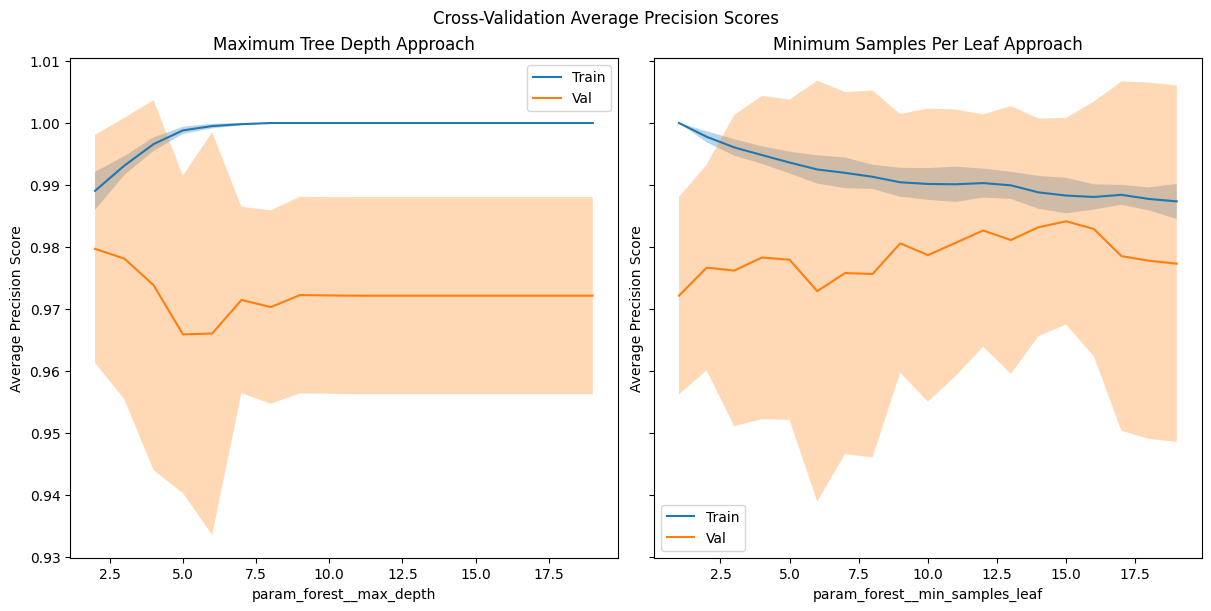

In [66]:
# Drop features (datsets do not leak since random_state kept constant)
X = df_encoded.drop(columns=['GENDER', 'CHEST_PAIN', 'LUNG_CANCER']).values
y = df_encoded['LUNG_CANCER'].values
feature_names = df_encoded.drop(columns=['GENDER', 'CHEST_PAIN', 'LUNG_CANCER']).columns

# Split X, y into train and test splits and stratify based on target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

# Split X_train, y_train into train and validation splits and stratify based on y_train (for feature importance scoring)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42, shuffle=True, stratify=y_train)

# Rebuild Pipeline Object
cat_features = determine_categorical_features(df_encoded.drop(['GENDER', 'CHEST_PAIN', 'LUNG_CANCER'], axis=1), numeric_features=['AGE'])

imb_pipe = Pipeline([('smotenc', SMOTENC(categorical_features=cat_features, random_state=42)),
                     ('forest', RandomForestClassifier(random_state=42))])

# Rebuild GridSearchCV Objects
grid1 = GridSearchCV(
    estimator=imb_pipe,
    param_grid=params1,
    scoring='average_precision',
    cv=5,
    return_train_score=True
)
grid2 = GridSearchCV(
    estimator=imb_pipe,
    param_grid=params2,
    scoring='average_precision',
    cv=5,
    return_train_score=True
)

# Train
grid1.fit(X_train, y_train)
grid2.fit(X_train, y_train)

# Plot results
cv_results1 = pd.DataFrame(grid1.cv_results_)[['param_forest__max_depth', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
cv_results2 = pd.DataFrame(grid2.cv_results_)[['param_forest__min_samples_leaf', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
plot_cv_results(cv_results1, cv_results2, x1='param_forest__max_depth', x2='param_forest__min_samples_leaf')

Continue with the minimum samples per leaf approach again.

In [67]:
# Verify we agree with GridSearchCV's best parameters
print(f'Best model parameters: {grid2.best_params_}')
print(f'Best model score: {grid2.best_score_}')

Best model parameters: {'forest__min_samples_leaf': 15}
Best model score: 0.9841371330465922


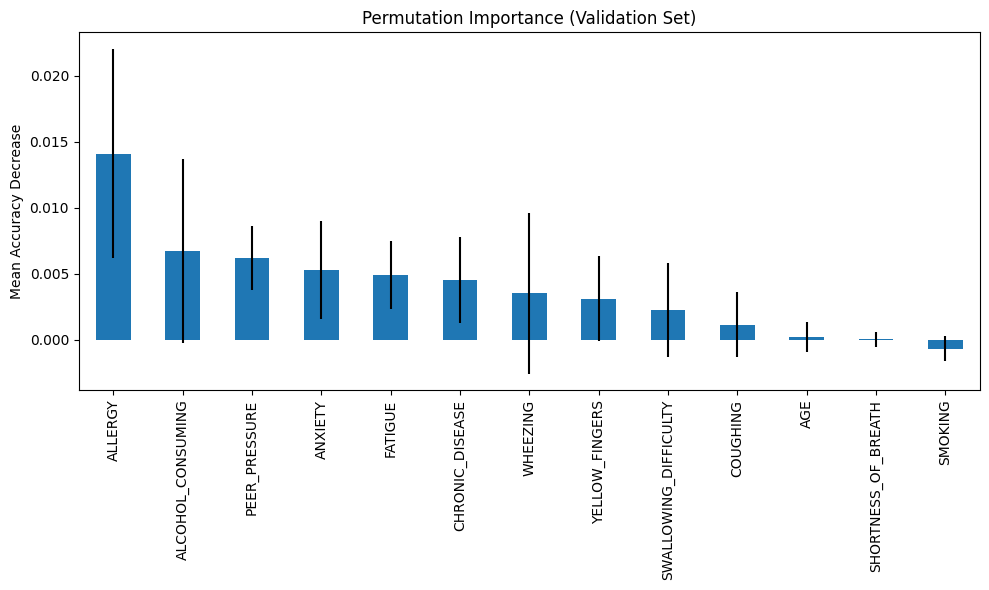

In [68]:
# Compute permutation importance
result = permutation_importance(grid2, X_val, y_val, n_repeats=30, random_state=42, scoring='average_precision')

# Create a sorted Series for plotting
importances = pd.Series(result.importances_mean, index=feature_names)
importances_std = pd.Series(result.importances_std, index=feature_names)
sorted_importances = importances.sort_values(ascending=False)

# Plot with matching error bars
fig, ax = plt.subplots(figsize=(10, 6))
sorted_importances.plot.bar(yerr=importances_std[sorted_importances.index], ax=ax)
ax.set_title("Permutation Importance (Validation Set)")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
plt.show()

Now, `SMOKING` is the only feature that shows that the model score is not affected by its shuffled values. Therefore, we should remove this feature and repeat the process. Note that `AGE` and `SHORTNESS_OF_BREATH` have near-zero impact. From the last test, these features are harldly improving the model's score, but they will not be touched, as their contribution may change after `SMOKING` is removed.

#### Iteration 3

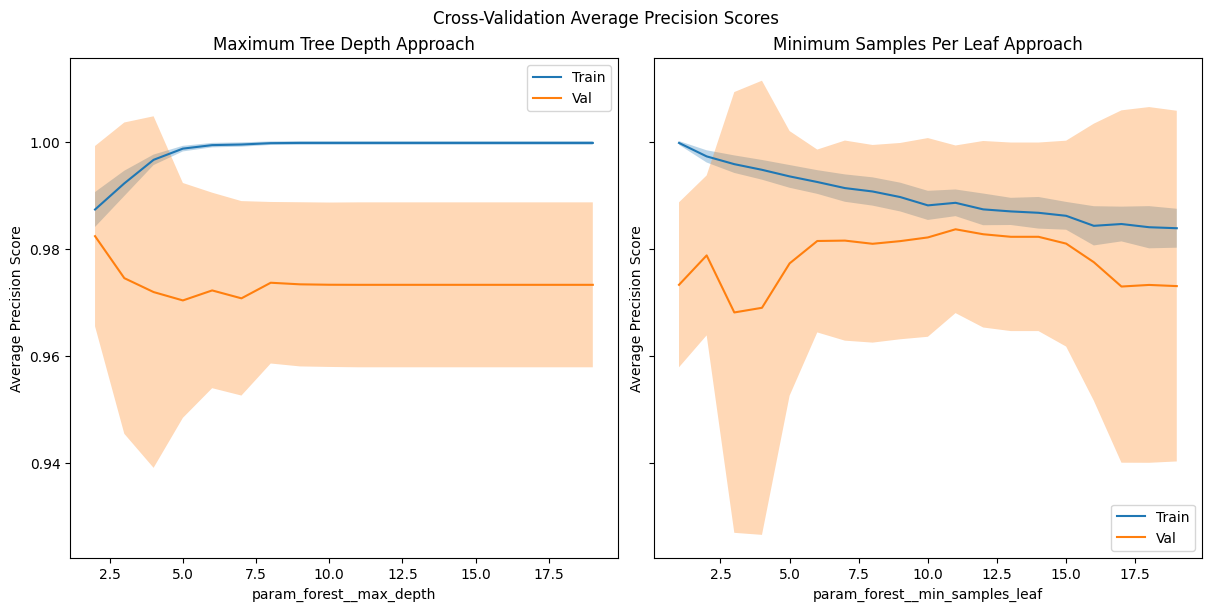

In [69]:
# Drop features (datsets do not leak since random_state kept constant)
X = df_encoded.drop(columns=['GENDER', 'CHEST_PAIN', 'SMOKING','LUNG_CANCER']).values
y = df_encoded['LUNG_CANCER'].values
feature_names = df_encoded.drop(columns=['GENDER', 'CHEST_PAIN', 'SMOKING', 'LUNG_CANCER']).columns

# Split X, y into train and test splits and stratify based on target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

# Split X_train, y_train into train and validation splits and stratify based on y_train (for feature importance scoring)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42, shuffle=True, stratify=y_train)

# Rebuild Pipeline Object
cat_features = determine_categorical_features(df_encoded.drop(['GENDER', 'CHEST_PAIN', 'SMOKING', 'LUNG_CANCER'], axis=1), numeric_features=['AGE'])

imb_pipe = Pipeline([('smotenc', SMOTENC(categorical_features=cat_features, random_state=42)),
                     ('forest', RandomForestClassifier(random_state=42))])

# Rebuild GridSearchCV Objects
grid1 = GridSearchCV(
    estimator=imb_pipe,
    param_grid=params1,
    scoring='average_precision',
    cv=5,
    return_train_score=True
)
grid2 = GridSearchCV(
    estimator=imb_pipe,
    param_grid=params2,
    scoring='average_precision',
    cv=5,
    return_train_score=True
)

# Train
grid1.fit(X_train, y_train)
grid2.fit(X_train, y_train)

# Plot results
cv_results1 = pd.DataFrame(grid1.cv_results_)[['param_forest__max_depth', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
cv_results2 = pd.DataFrame(grid2.cv_results_)[['param_forest__min_samples_leaf', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
plot_cv_results(cv_results1, cv_results2, x1='param_forest__max_depth', x2='param_forest__min_samples_leaf')

Continue with the minimum samples per leaf approach again.

In [70]:
# Verify we agree with GridSearchCV's best parameters
print(f'Best model parameters: {grid2.best_params_}')
print(f'Best model score: {grid2.best_score_}')

Best model parameters: {'forest__min_samples_leaf': 11}
Best model score: 0.9836944730495845


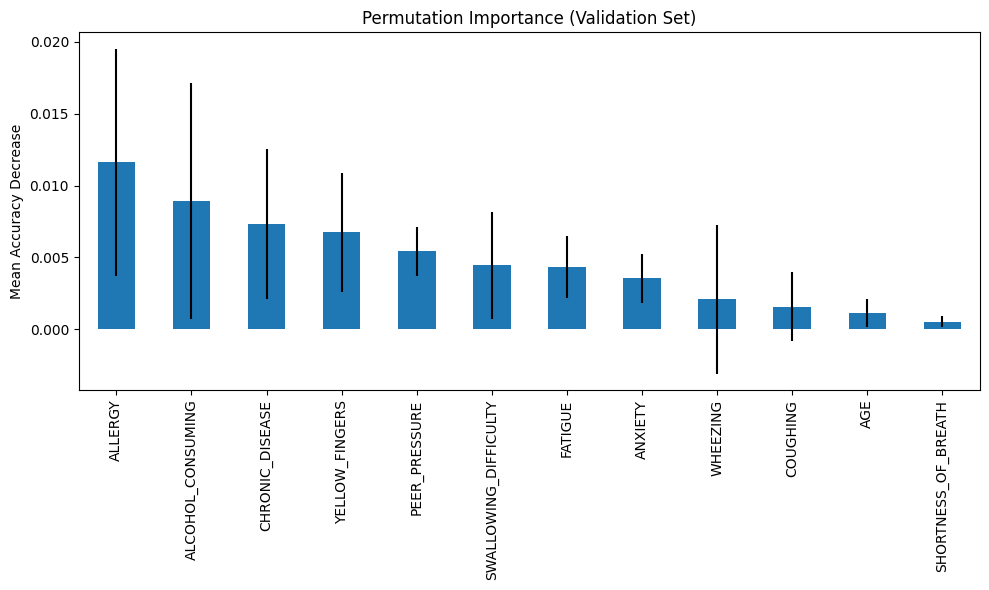

In [71]:
# Compute permutation importance
result = permutation_importance(grid2, X_val, y_val, n_repeats=30, random_state=42, scoring='average_precision')

# Create a sorted Series for plotting
importances = pd.Series(result.importances_mean, index=feature_names)
importances_std = pd.Series(result.importances_std, index=feature_names)
sorted_importances = importances.sort_values(ascending=False)

# Plot with matching error bars
fig, ax = plt.subplots(figsize=(10, 6))
sorted_importances.plot.bar(yerr=importances_std[sorted_importances.index], ax=ax)
ax.set_title("Permutation Importance (Validation Set)")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
plt.show()

Now, all features show that when their values are permuted, the model's mean accuracy decreases. This means that these remaining features positively contribute to the model's predition power.

Great! We are now left with a model that benefits from each feature in its dataset. Let's highlight our final model and how we got here.

In [72]:
# View best model parameters
print(f'Best model parameters: {grid2.best_params_}')
print(f'Best model score: {grid2.best_score_}')

# Selected features
final_features = df_encoded.drop(columns=['GENDER', 'CHEST_PAIN', 'SMOKING', 'LUNG_CANCER']).columns.to_list()
print(f'\nSelected features: {final_features}')

Best model parameters: {'forest__min_samples_leaf': 11}
Best model score: 0.9836944730495845

Selected features: ['AGE', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE', 'CHRONIC_DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING', 'ALCOHOL_CONSUMING', 'COUGHING', 'SHORTNESS_OF_BREATH', 'SWALLOWING_DIFFICULTY']


The best RandomForestClassifier model had the minimum samples required for the creation of a leaf node set to 11 samples. This was found through a cross-validation hyperparameter study where two approaches were compared: limiting the maximum depth of a tree and requiring a minimum number of samples for a leaf node to be created in a tree. Due to the target class being highly imbalanced, the SMOTE oversampling technique was employed to oversample the minority class to be the size of the majority class with the goal of reducing training bias. Note that the cross-validation hold out test sets were not oversampled -- only the training data within each fold of the cross-validation splits. As each cross-validation split and all other splits used for scoring the model performance were not oversampled and thus contained imbalanced data, the average precision score was used to equally emphasize the importance of limiting False Positives and False Negatives.

## Model Performance against Number of Features

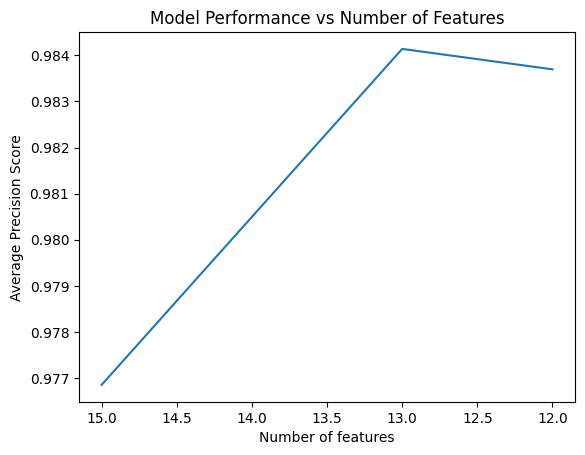

In [73]:
# Selected features by iteration
features_by_iteration = [df_encoded.drop('LUNG_CANCER', axis=1).columns.tolist(),
                         df_encoded.drop(columns=['GENDER', 'CHEST_PAIN', 'LUNG_CANCER']).columns.tolist(),
                         df_encoded.drop(columns=['GENDER', 'CHEST_PAIN', 'SMOKING', 'LUNG_CANCER']).columns.tolist()]
feature_lengths = [len(feats) for feats in features_by_iteration]

# Model score by iteration
model_scores = [0.9768531368448583, 0.9841371330465922, 0.9836944730495845]

# Plot
plt.plot(feature_lengths, model_scores)
ax = plt.gca()
ax.invert_xaxis()
plt.xlabel('Number of features')
plt.ylabel('Average Precision Score')
plt.title('Model Performance vs Number of Features')
plt.show()

An important question to ask is: how did removing features from my dataset affect my model's ability to predict lung cancer presence? Well, for the most part, it actually improved!

## Final Model Performance on Test Set (w/ SMOTE)
Now that we have the criteria for our best model and determined the survey questions that positively impact its prediction performance, let's train on all data that doesn't belong to the original test set.

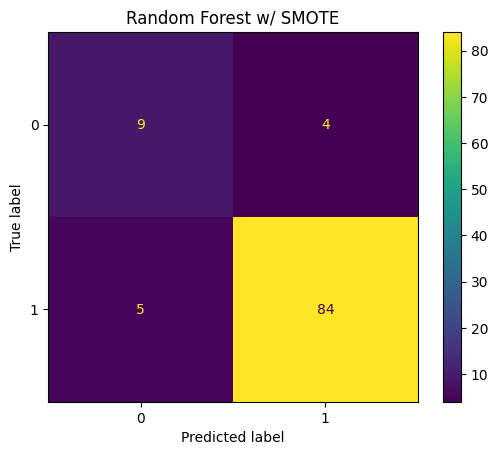

Precision = 0.9545454545454546
recall = 0.9438202247191011
f1 = 0.9491525423728814
support = None


In [74]:
# Drop features (datasets do not leak since random_state kept constant)
X = df_encoded[final_features].values
y = df_encoded['LUNG_CANCER'].values

# Split X, y into train and test splits and stratify based on target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

# Rebuild Pipeline Object
cat_features = determine_categorical_features(df_encoded[final_features], numeric_features=['AGE'])

imb_pipe = Pipeline([('smotenc', SMOTENC(categorical_features=cat_features, random_state=42)),
                     ('forest', RandomForestClassifier(min_samples_leaf=11, random_state=42))])

# Fit the Pipeline
imb_pipe.fit(X_train, y_train)

# Evaluate the Pipeline
y_pred = imb_pipe.predict(X_test)

# View confusion matrix
cm_w_smote = confusion_matrix(y_test, y_pred)
disp_w_smote = ConfusionMatrixDisplay(confusion_matrix=cm_w_smote)
disp_w_smote.plot()
plt.title('Random Forest w/ SMOTE')
plt.show()

# Print Precision, Recall, F1, Support
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f'Precision = {precision}')
print(f'recall = {recall}')
print(f'f1 = {f1}')
print(f'support = {support}')

## Same Analysis of RF w/o SMOTE
To compare the final model trained on oversampled data, it is only fair to do so against a model that went through the same hyperparameter tuning and feature selection process. The following work does exactly this, but with minimal comments to avoid clutter.

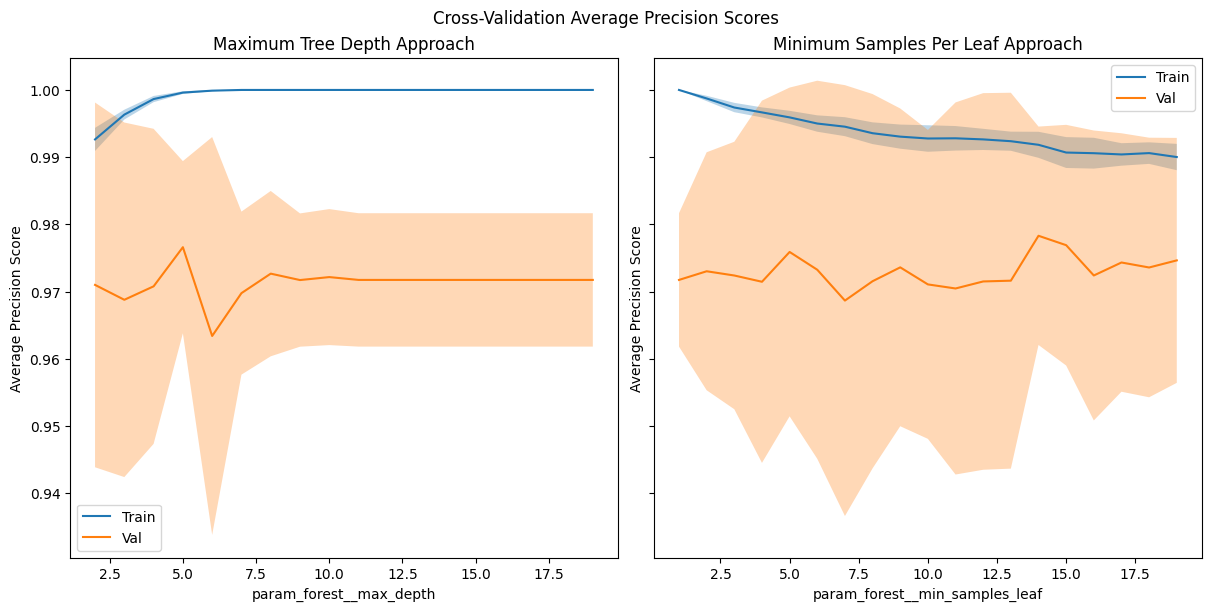

In [75]:
# Separate features from target
X = df_encoded.drop('LUNG_CANCER', axis=1).values
y = df_encoded['LUNG_CANCER'].values
feature_names = df_encoded.drop('LUNG_CANCER', axis=1).columns

# Split X, y into train and test splits and stratify based on target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

# Split X_train, y_train into train and validation splits and stratify based on y_train (for feature importance scoring)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42, shuffle=True, stratify=y_train)

# Define Pipeline object
pipe = Pipeline([('forest', RandomForestClassifier(random_state=42))])

# Define parameter grids for both approaches
params1 = {'forest__max_depth': list(range(2, 20))}
params2 = {'forest__min_samples_leaf': list(range(1, 20))}

# Create Grid Search objects
grid1 = GridSearchCV(
    estimator=pipe,
    param_grid=params1,
    scoring='average_precision',
    cv=5,
    return_train_score=True
)
grid2 = GridSearchCV(
    estimator=pipe,
    param_grid=params2,
    scoring='average_precision',
    cv=5,
    return_train_score=True
)

# Train
grid1.fit(X_train, y_train)
grid2.fit(X_train, y_train)

# Plot results
cv_results1 = pd.DataFrame(grid1.cv_results_)[['param_forest__max_depth', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
cv_results2 = pd.DataFrame(grid2.cv_results_)[['param_forest__min_samples_leaf', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
plot_cv_results(cv_results1, cv_results2, x1='param_forest__max_depth', x2='param_forest__min_samples_leaf')

In [76]:
# Verify we agree with GridSearchCV's best parameters
print(f'Best model parameters: {grid2.best_params_}')
print(f'Best model score: {grid2.best_score_}')

Best model parameters: {'forest__min_samples_leaf': 14}
Best model score: 0.9782966234243489


#### Iteration 1

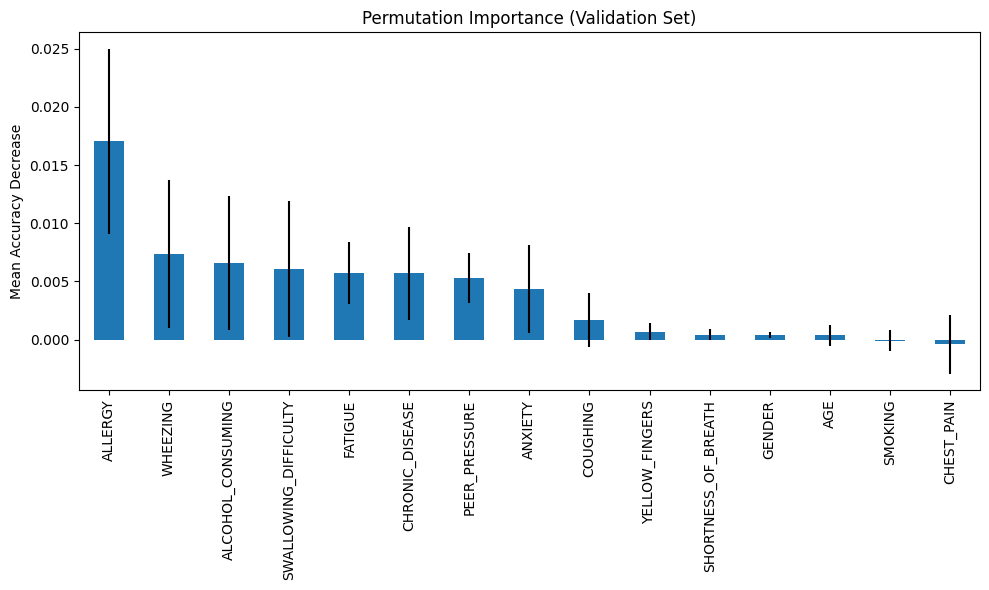

In [77]:
# Compute permutation importance
result = permutation_importance(grid2, X_val, y_val, n_repeats=30, random_state=42, scoring='average_precision')

# Create a sorted Series for plotting
importances = pd.Series(result.importances_mean, index=feature_names)
importances_std = pd.Series(result.importances_std, index=feature_names)
sorted_importances = importances.sort_values(ascending=False)

# Plot with matching error bars
fig, ax = plt.subplots(figsize=(10, 6))
sorted_importances.plot.bar(yerr=importances_std[sorted_importances.index], ax=ax)
ax.set_title("Permutation Importance (Validation Set)")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
plt.show()

In [78]:
sorted_importances

ALLERGY                  0.017020
WHEEZING                 0.007360
ALCOHOL_CONSUMING        0.006573
SWALLOWING_DIFFICULTY    0.006077
FATIGUE                  0.005725
CHRONIC_DISEASE          0.005683
PEER_PRESSURE            0.005273
ANXIETY                  0.004361
COUGHING                 0.001704
YELLOW_FINGERS           0.000682
SHORTNESS_OF_BREATH      0.000402
GENDER                   0.000400
AGE                      0.000371
SMOKING                 -0.000088
CHEST_PAIN              -0.000415
dtype: float64

Removing `SMOKING` and `CHEST_PAIN`.

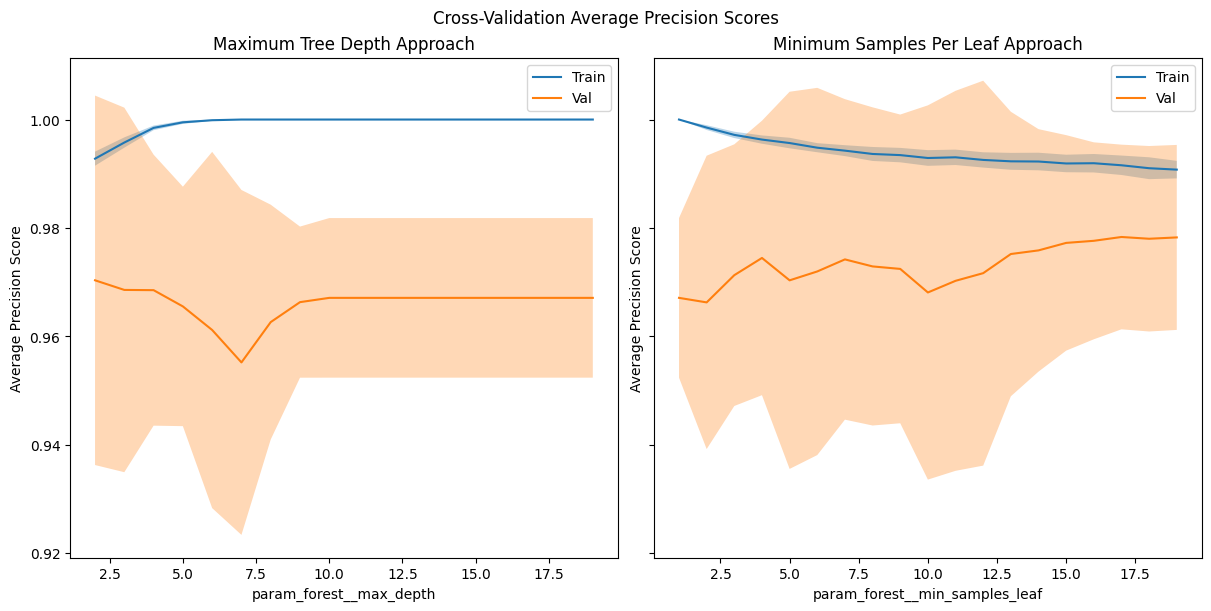

In [79]:
# Separate features from target
X = df_encoded.drop(columns=['SMOKING', 'CHEST_PAIN', 'LUNG_CANCER'], axis=1).values
y = df_encoded['LUNG_CANCER'].values
feature_names = df_encoded.drop(columns=['SMOKING', 'CHEST_PAIN', 'LUNG_CANCER'], axis=1).columns

# Split X, y into train and test splits and stratify based on target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

# Split X_train, y_train into train and validation splits and stratify based on y_train (for feature importance scoring)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42, shuffle=True, stratify=y_train)

# Define Pipeline object
pipe = Pipeline([('forest', RandomForestClassifier(random_state=42))])

# Define parameter grids for both approaches
params1 = {'forest__max_depth': list(range(2, 20))}
params2 = {'forest__min_samples_leaf': list(range(1, 20))}

# Create Grid Search objects
grid1 = GridSearchCV(
    estimator=pipe,
    param_grid=params1,
    scoring='average_precision',
    cv=5,
    return_train_score=True
)
grid2 = GridSearchCV(
    estimator=pipe,
    param_grid=params2,
    scoring='average_precision',
    cv=5,
    return_train_score=True
)

# Train
grid1.fit(X_train, y_train)
grid2.fit(X_train, y_train)

# Plot results
cv_results1 = pd.DataFrame(grid1.cv_results_)[['param_forest__max_depth', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
cv_results2 = pd.DataFrame(grid2.cv_results_)[['param_forest__min_samples_leaf', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
plot_cv_results(cv_results1, cv_results2, x1='param_forest__max_depth', x2='param_forest__min_samples_leaf')

In [80]:
# Verify we agree with GridSearchCV's best parameters
print(f'Best model parameters: {grid2.best_params_}')
print(f'Best model score: {grid2.best_score_}')

Best model parameters: {'forest__min_samples_leaf': 17}
Best model score: 0.9783400297136968


#### Iteration 2

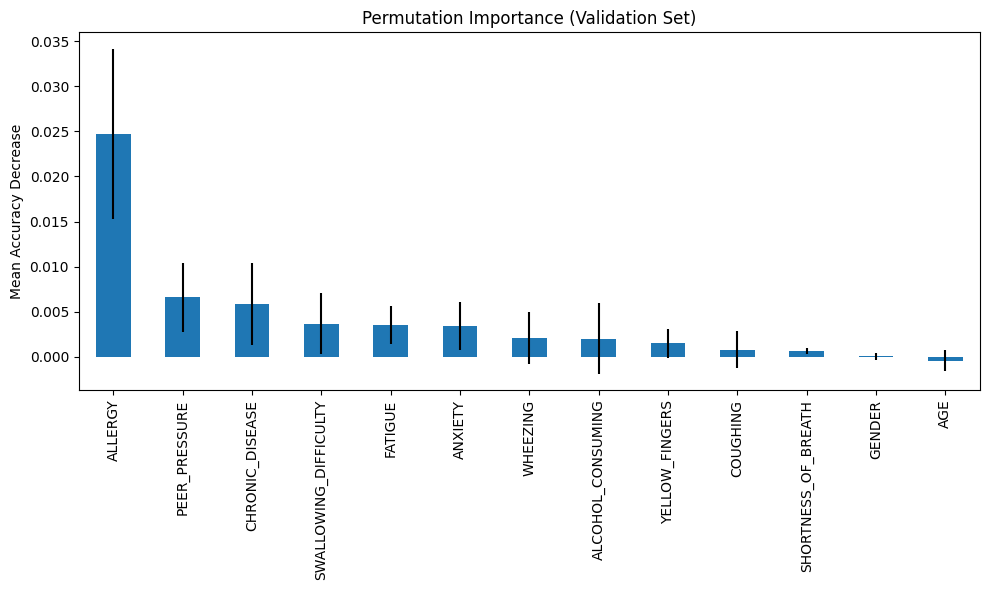

In [81]:
# Compute permutation importance
result = permutation_importance(grid2, X_val, y_val, n_repeats=30, random_state=42, scoring='average_precision')

# Create a sorted Series for plotting
importances = pd.Series(result.importances_mean, index=feature_names)
importances_std = pd.Series(result.importances_std, index=feature_names)
sorted_importances = importances.sort_values(ascending=False)

# Plot with matching error bars
fig, ax = plt.subplots(figsize=(10, 6))
sorted_importances.plot.bar(yerr=importances_std[sorted_importances.index], ax=ax)
ax.set_title("Permutation Importance (Validation Set)")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
plt.show()

In [82]:
sorted_importances

ALLERGY                  0.024743
PEER_PRESSURE            0.006603
CHRONIC_DISEASE          0.005827
SWALLOWING_DIFFICULTY    0.003679
FATIGUE                  0.003471
ANXIETY                  0.003424
WHEEZING                 0.002109
ALCOHOL_CONSUMING        0.002027
YELLOW_FINGERS           0.001490
COUGHING                 0.000803
SHORTNESS_OF_BREATH      0.000613
GENDER                   0.000043
AGE                     -0.000439
dtype: float64

Removing `AGE`.

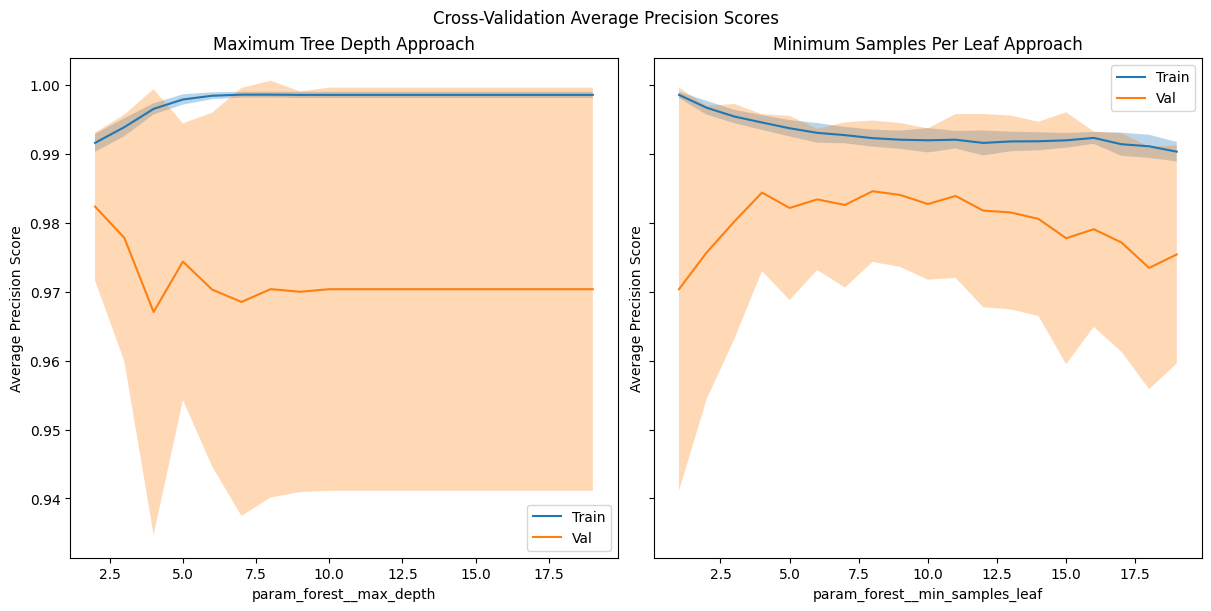

In [83]:
# Separate features from target
X = df_encoded.drop(columns=['SMOKING', 'CHEST_PAIN', 'AGE', 'LUNG_CANCER'], axis=1).values
y = df_encoded['LUNG_CANCER'].values
feature_names = df_encoded.drop(columns=['SMOKING', 'CHEST_PAIN', 'AGE', 'LUNG_CANCER'], axis=1).columns

# Split X, y into train and test splits and stratify based on target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

# Split X_train, y_train into train and validation splits and stratify based on y_train (for feature importance scoring)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42, shuffle=True, stratify=y_train)

# Define Pipeline object
pipe = Pipeline([('forest', RandomForestClassifier(random_state=42))])

# Define parameter grids for both approaches
params1 = {'forest__max_depth': list(range(2, 20))}
params2 = {'forest__min_samples_leaf': list(range(1, 20))}

# Create Grid Search objects
grid1 = GridSearchCV(
    estimator=pipe,
    param_grid=params1,
    scoring='average_precision',
    cv=5,
    return_train_score=True
)
grid2 = GridSearchCV(
    estimator=pipe,
    param_grid=params2,
    scoring='average_precision',
    cv=5,
    return_train_score=True
)

# Train
grid1.fit(X_train, y_train)
grid2.fit(X_train, y_train)

# Plot results
cv_results1 = pd.DataFrame(grid1.cv_results_)[['param_forest__max_depth', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
cv_results2 = pd.DataFrame(grid2.cv_results_)[['param_forest__min_samples_leaf', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
plot_cv_results(cv_results1, cv_results2, x1='param_forest__max_depth', x2='param_forest__min_samples_leaf')

In [84]:
# Verify we agree with GridSearchCV's best parameters
print(f'Best model parameters: {grid2.best_params_}')
print(f'Best model score: {grid2.best_score_}')

Best model parameters: {'forest__min_samples_leaf': 8}
Best model score: 0.9846146745638935


#### Iteration 3

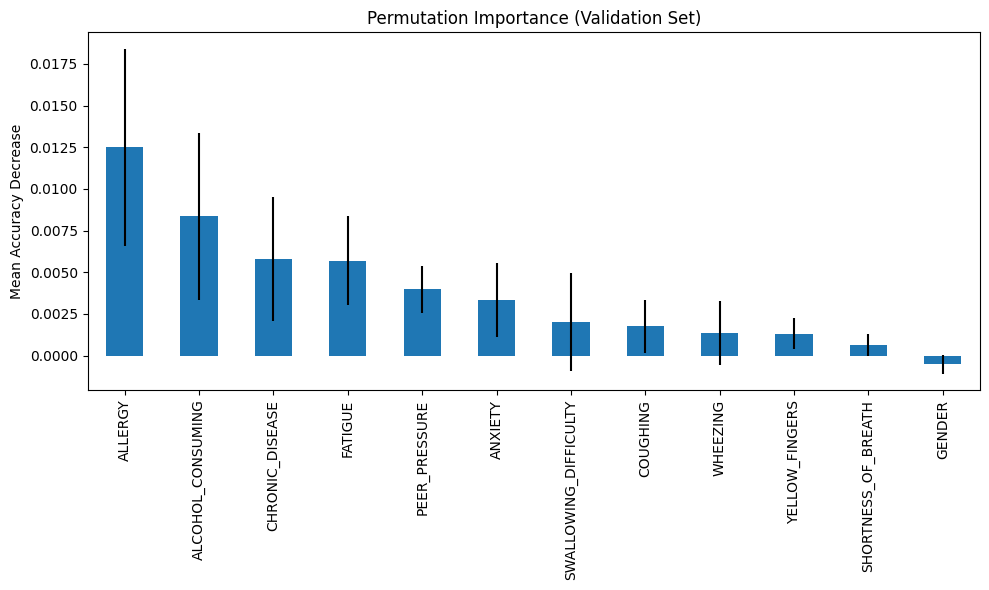

In [85]:
# Compute permutation importance
result = permutation_importance(grid2, X_val, y_val, n_repeats=30, random_state=42, scoring='average_precision')

# Create a sorted Series for plotting
importances = pd.Series(result.importances_mean, index=feature_names)
importances_std = pd.Series(result.importances_std, index=feature_names)
sorted_importances = importances.sort_values(ascending=False)

# Plot with matching error bars
fig, ax = plt.subplots(figsize=(10, 6))
sorted_importances.plot.bar(yerr=importances_std[sorted_importances.index], ax=ax)
ax.set_title("Permutation Importance (Validation Set)")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
plt.show()

Removing `GENDER`.

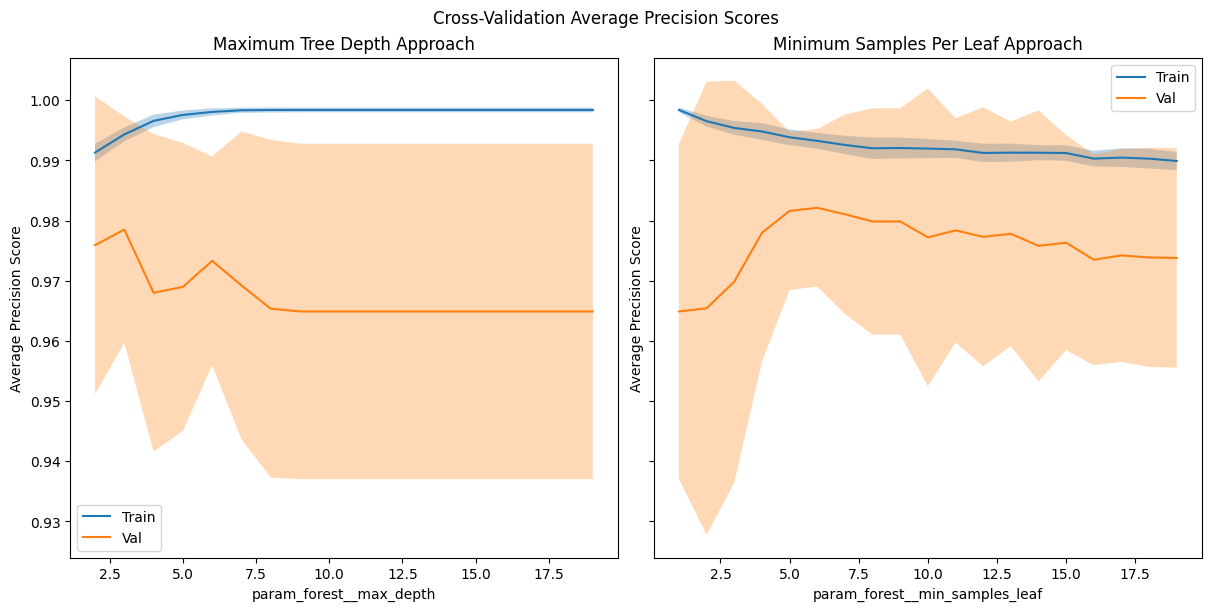

In [86]:
# Separate features from target
X = df_encoded.drop(columns=['SMOKING', 'CHEST_PAIN', 'AGE', 'GENDER', 'LUNG_CANCER'], axis=1).values
y = df_encoded['LUNG_CANCER'].values
feature_names = df_encoded.drop(columns=['SMOKING', 'CHEST_PAIN', 'AGE', 'GENDER', 'LUNG_CANCER'], axis=1).columns

# Split X, y into train and test splits and stratify based on target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

# Split X_train, y_train into train and validation splits and stratify based on y_train (for feature importance scoring)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42, shuffle=True, stratify=y_train)

# Define Pipeline object
pipe = Pipeline([('forest', RandomForestClassifier(random_state=42))])

# Define parameter grids for both approaches
params1 = {'forest__max_depth': list(range(2, 20))}
params2 = {'forest__min_samples_leaf': list(range(1, 20))}

# Create Grid Search objects
grid1 = GridSearchCV(
    estimator=pipe,
    param_grid=params1,
    scoring='average_precision',
    cv=5,
    return_train_score=True
)
grid2 = GridSearchCV(
    estimator=pipe,
    param_grid=params2,
    scoring='average_precision',
    cv=5,
    return_train_score=True
)

# Train
grid1.fit(X_train, y_train)
grid2.fit(X_train, y_train)

# Plot results
cv_results1 = pd.DataFrame(grid1.cv_results_)[['param_forest__max_depth', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
cv_results2 = pd.DataFrame(grid2.cv_results_)[['param_forest__min_samples_leaf', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
plot_cv_results(cv_results1, cv_results2, x1='param_forest__max_depth', x2='param_forest__min_samples_leaf')

In [87]:
# Verify we agree with GridSearchCV's best parameters
print(f'Best model parameters: {grid2.best_params_}')
print(f'Best model score: {grid2.best_score_}')

Best model parameters: {'forest__min_samples_leaf': 6}
Best model score: 0.9821357970044667


#### Iteration 4

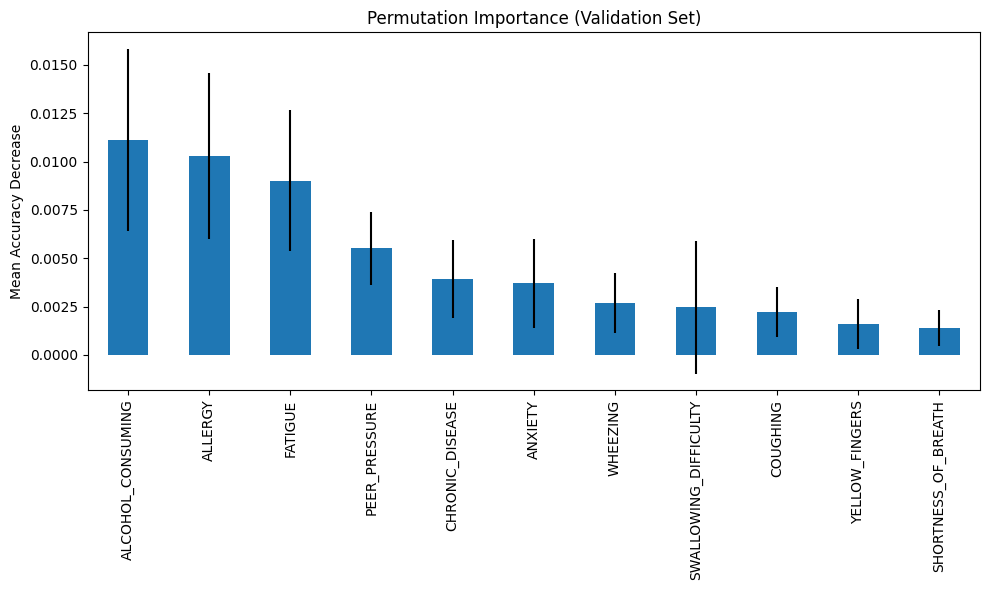

In [88]:
# Compute permutation importance
result = permutation_importance(grid2, X_val, y_val, n_repeats=30, random_state=42, scoring='average_precision')

# Create a sorted Series for plotting
importances = pd.Series(result.importances_mean, index=feature_names)
importances_std = pd.Series(result.importances_std, index=feature_names)
sorted_importances = importances.sort_values(ascending=False)

# Plot with matching error bars
fig, ax = plt.subplots(figsize=(10, 6))
sorted_importances.plot.bar(yerr=importances_std[sorted_importances.index], ax=ax)
ax.set_title("Permutation Importance (Validation Set)")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
plt.show()

All features positively contribute to model prediction power.

In [89]:
# View best model parameters
print(f'Best model parameters: {grid2.best_params_}')
print(f'Best model score: {grid2.best_score_}')

# Selected features
final_features = df_encoded.drop(columns=['SMOKING', 'CHEST_PAIN', 'AGE', 'GENDER', 'LUNG_CANCER']).columns.to_list()
print(f'\nSelected features: {final_features}')

Best model parameters: {'forest__min_samples_leaf': 6}
Best model score: 0.9821357970044667

Selected features: ['YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE', 'CHRONIC_DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING', 'ALCOHOL_CONSUMING', 'COUGHING', 'SHORTNESS_OF_BREATH', 'SWALLOWING_DIFFICULTY']


## Model Performance against Number of Features

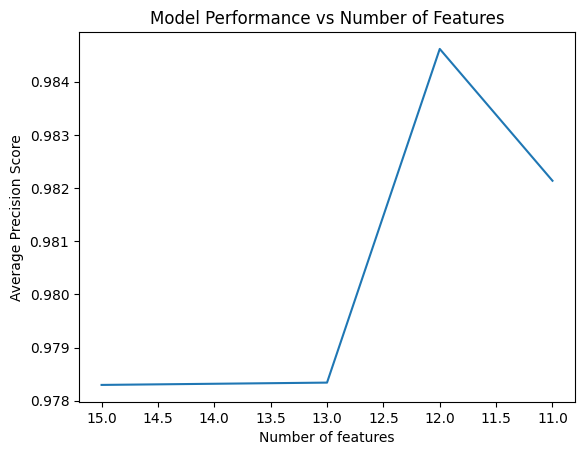

In [90]:
# Selected features by iteration
features_by_iteration = [df_encoded.drop('LUNG_CANCER', axis=1).columns.tolist(),
                         df_encoded.drop(columns=['SMOKING', 'CHEST_PAIN', 'LUNG_CANCER']).columns.tolist(),
                         df_encoded.drop(columns=['SMOKING', 'CHEST_PAIN', 'AGE', 'LUNG_CANCER']).columns.tolist(),
                         df_encoded.drop(columns=['SMOKING', 'CHEST_PAIN', 'AGE', 'GENDER', 'LUNG_CANCER']).columns.tolist()]
feature_lengths = [len(feats) for feats in features_by_iteration]

# Model score by iteration
model_scores = [0.9782966234243489, 0.9783400297136968, 0.9846146745638935, 0.9821357970044667]

# Plot
plt.plot(feature_lengths, model_scores)
ax = plt.gca()
ax.invert_xaxis()
plt.xlabel('Number of features')
plt.ylabel('Average Precision Score')
plt.title('Model Performance vs Number of Features')
plt.show()

Without oversampling the minority class with SMOTE, the average precision score of the RandomForestClassifier still improves with the removal of features that don't contribute to model prediction performance.

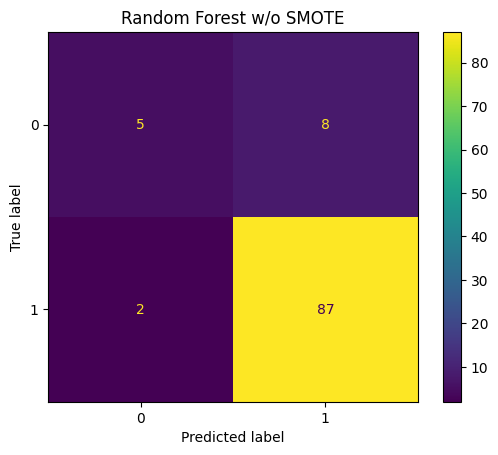

Precision = 0.9157894736842105
recall = 0.9775280898876404
f1 = 0.9456521739130435
support = None


In [91]:
# Drop features (datasets do not leak since random_state kept constant)
X = df_encoded[final_features].values
y = df_encoded['LUNG_CANCER'].values

# Split X, y into train and test splits and stratify based on target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

# Rebuild Pipeline Object
pipe = Pipeline([('forest', RandomForestClassifier(min_samples_leaf=6, random_state=42))])

# Fit the Pipeline
pipe.fit(X_train, y_train)

# Evaluate the Pipeline
y_pred = pipe.predict(X_test)

# View confusion matrix
cm_wo_smote = confusion_matrix(y_test, y_pred)
disp_wo_smote = ConfusionMatrixDisplay(confusion_matrix=cm_wo_smote)
disp_wo_smote.plot()
plt.title('Random Forest w/o SMOTE')
plt.show()

# Print Precision, Recall, F1, Support
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f'Precision = {precision}')
print(f'recall = {recall}')
print(f'f1 = {f1}')
print(f'support = {support}')

## Side by Side Comparison: w/ SMOTE vs w/o SMOTE

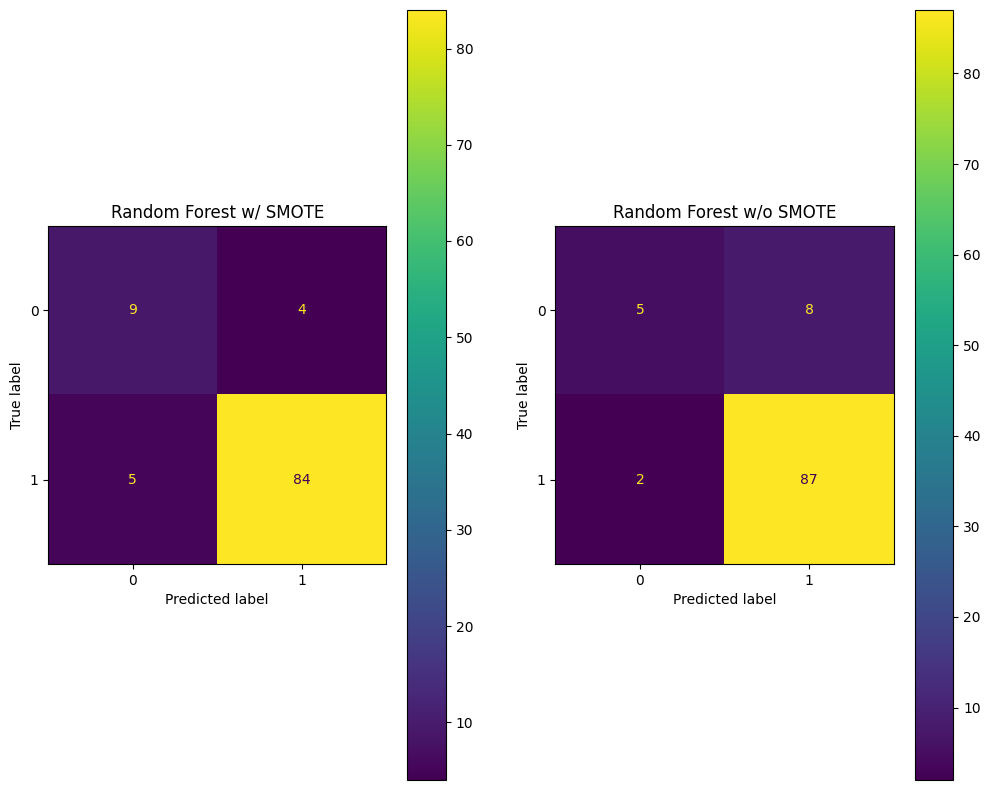

In [92]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 10))
disp_w_smote.plot(ax=ax1)
ax1.set_title('Random Forest w/ SMOTE')
disp_wo_smote.plot(ax=ax2)
ax2.set_title('Random Forest w/o SMOTE')
plt.show()

## Results

Without employing the SMOTE oversampling technique (right), the RandomForestClassifier was trained on biased data. This bias comes from the majority of samples being for the positive target class. Therefore, the model had many times more instances to reward predicting a sample belongs to the positive class than it did for the negative class. Ultimately, this resulted in a model that produces more false positives.

When the SMOTE oversampling technique *was* employed (left), the RandomForestClassifier was trained on artificially unbiased data. This allowed a balance between the model's False Positive and False Negative predictions. This resulted in the model trained using SMOTE to correctly predict one more sample (9+84=93) than the model trained without using SMOTE (5+87=92).

## Conclusions and Recommendations
Ultimately, employing the SMOTE oversampling technique improved the RandomForestClassifier performance by balancing the model's ability to predict both positive and negative classes. The model that did not use SMOTE ended up favoring positive predictions due to the biased dataset it was trained on.

In addition to producing a more well-rounded model, permutation-based feature importance was considered to determine how much the survey questions contribute to the model's prediction. It was found that three survey questions (in the SMOTE analysis) had no impact on model prediction. Specifically, these survey questions were `GENDER`, `CHEST_PAIN`, and `SMOKING`. I recommend the removal of these survey questions to not only improve the model performance, but to also reduce survey fatigue. Respondents will likely be pleased to partake in a shorter survey. Another perspective is that there would not be room for three new questions to be asked if further research were to be done on this topic, without increasing the length of the original survey.

## Next Steps
The use of SMOTE oversampling in this notebook did not alter the default hyperparameters. Therefore, the number of neighboring points used to classify the synthetic samples remained at 5. There could be improvements to be made to the model if this were altered. I suggest an additional study to do exactly this.

Thank you for checking out my notebook!